In [1]:
import networkx as nx
import pickle
import random
import scipy
from scipy.sparse import tril, find
import django
import sys, os
import pandas as pd
import matplotlib.pyplot as plt
import igraph
from django.core.management import call_command

sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *
from tmv_app.tasks import *
import tmv_app
import tmv_app.utils.plotting as tplots
from tmv_app.utils.plotting import SquareCollection, CoordSquare

### We start by loading up a model and calculating/loading the tsne positions of its documents

In [2]:
run_id = 1691
stat = RunStats.objects.get(pk=run_id)
q = stat.query

# position the papers in a 2-dimensional topic space, with perplexity p
# unless you pass the argument force_overwrite=True, the results are not recalculated
s = 0
p = 50
tsne_results, r_ind = stat.calculate_tsne('tsne_results/data', p)

We've already calculated the required matrices!
We've already calculated the tsne positions


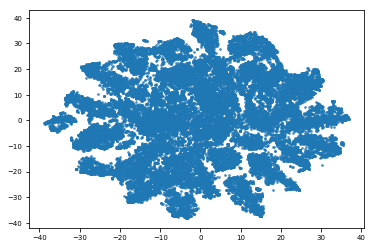

In [3]:
plt.scatter(tsne_results[:,0],tsne_results[:,1], s=3, alpha=0.7)

### We have a cloud of dots! Now we can overlay the dots' properties

In [4]:
colors = ['#7fc97f','#beaed4','#fdc086','#ffff99','#386cb0','#f0027f','#F0F0F0']
no_oecd_ids = r_ind

oecd_cats = [
    {'wc__oecd': 'Agricultural Sciences'},
    {'wc__oecd': 'Engineering and Technology'},
    {'wc__oecd': 'Humanities'},
    {'wc__oecd': 'Medical and Health Sciences'},
    {'wc__oecd': 'Natural Sciences'},
    {'wc__oecd': 'Social Sciences'},
    {'wc__oecd': None}
]

oecd_df = pd.DataFrame()
for i,c in enumerate(oecd_cats):
    ds = Doc.objects.filter(query=q,wc__oecd=c['wc__oecd']).values_list('id', flat=True)
    c['docs'] = list(set(ds) & set(r_ind))
    oecd_df = pd.concat([oecd_df,pd.DataFrame({
        "oecd": c['wc__oecd'], "doc": c['docs']
    })])
    c['n_docs'] = len(c['docs'])
    c['name'] = c['wc__oecd']
    c['color'] = colors[i]
    c["dis"] = np.argwhere(np.isin(r_ind,c['docs']))
    no_oecd_ids = no_oecd_ids[np.isin(no_oecd_ids,c['docs'],invert=True)]
    
from operator import itemgetter
oecd_cats = sorted(oecd_cats, key=itemgetter('n_docs'), reverse=True)


calculating points took 0.606s.
[-50. -40. -30. -20. -10.   0.  10.  20.  30.  40.  50.]


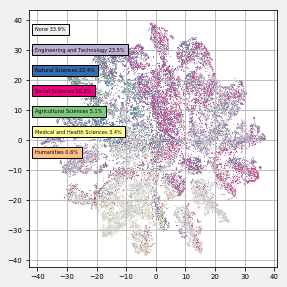

In [5]:
# Produce one plot first and summarise the squares
import importlib
importlib.reload(tmv_app.utils.plotting)

plt.close()

fig, ax = plt.subplots( figsize=(4,4))
tplots.plot_tsne(r_ind,tsne_results,oecd_cats,no_oecd_ids,verbose=True,ax=ax)

fig.patch.set_facecolor('#f0f0f0') 

fig.tight_layout()
for extension in ["png","svg"]:
    plt.savefig(
        f'plots/tsne_results/run_{run_id}_s_{s}_p{p}_oecds.{extension}',
        bbox_inches='tight',
        facecolor=fig.get_facecolor(),
        pad_inches=0.2
    )

sc = SquareCollection()   
xs = plt.xticks()[0]
ys = plt.yticks()[0]

print(xs)

for i, x1 in enumerate(xs):
    if i==len(xs)-1:
        break
    x2 = xs[i+1]
    for j, y1 in enumerate(ys):
        if j==len(ys)-1:
            break
        y2 = ys[j+1]

        cs = CoordSquare(x1,x2,y1,y2,r_ind,tsne_results,0)
        cs.get_points()
        sc.add(cs)
    
plt.show()

### Hm, it seems like we have no disciplinary information for many of the documents - perhaps that could be something to do with how they were imported?

The number below shows the number of documents with missing information in the web of science category field (N.B. many of the documents will already have been in the database, so might already have that field populated)

In [9]:
Doc.objects.filter(query=q,wosarticle__wc__isnull=True).count()

14712

calculating points took 0.545s.


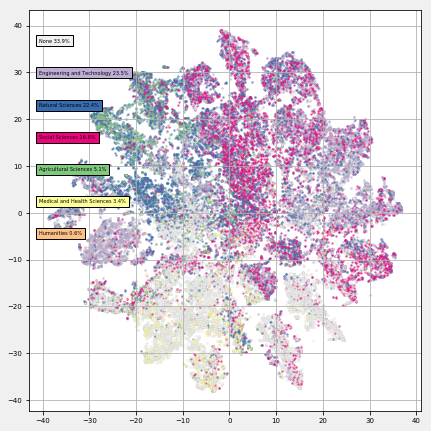

In [6]:
import importlib
importlib.reload(tmv_app.utils.plotting)

plt.close()

fig, ax = plt.subplots( figsize=(6,6))
tplots.plot_tsne(
    r_ind,
    tsne_results,
    oecd_cats,
    no_oecd_ids,
    verbose=True,
    ax=ax,
    psize=5 #pointsize
)

fig.patch.set_facecolor('#f0f0f0') 

fig.tight_layout()
for extension in ["png","svg"]:
    plt.savefig(
        f'plots/tsne_results/run_{run_id}_s_{s}_p{p}_oecds.{extension}',
        bbox_inches='tight',
        facecolor=fig.get_facecolor(),
        pad_inches=0.2
    )

calculating points took 0.376s.


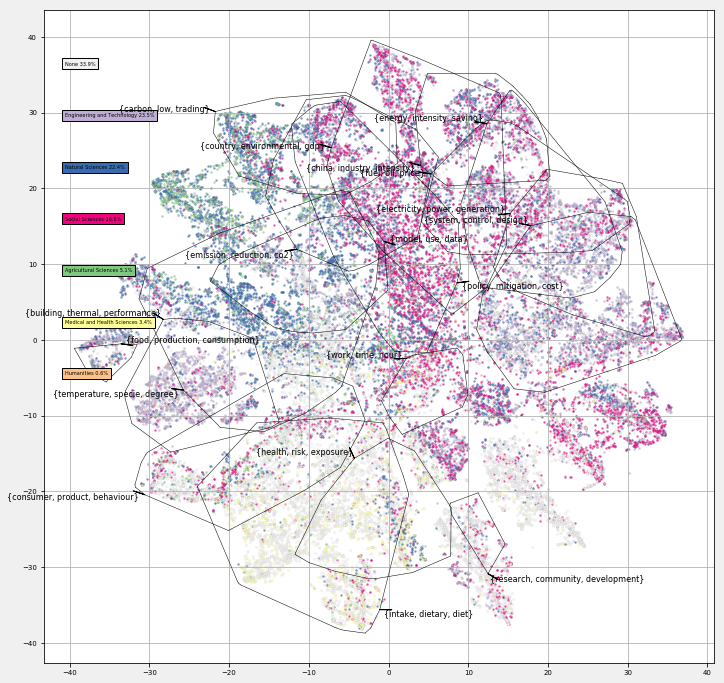

In [11]:
import importlib
importlib.reload(tmv_app.utils.plotting)

tops = Topic.objects.filter(
    run_id=run_id,
    share__gt=0.03 # Only include the larger topics, to prevent the map getting too full labels
)


fig, ax = plt.subplots( figsize=(12,12))
tplots.plot_tsne(
    r_ind,
    tsne_results,
    oecd_cats,
    no_oecd_ids,
    verbose=True,
    ax=ax,
    psize=5, #pointsize
    topics=tops,
    t_thresh=0.8,
    eps=3 # Input for clustering, higher values allow larger distances between docs 
)

fig.patch.set_facecolor('#f0f0f0') 

plt.show()

### That's nice, although a little messy, perhaps we can try with the categories we input as the queries

The labels are drawn around clusters of points relevant to the topics provided

In [17]:
short_name_dict = {
    "Sufficiency and distributional analyses in the demand side of climate change mitigation":"Sufficiency",
    "Determinants of low-carbon transport mode adoption: Systematic review of reviews": "Transport",
    "Status consciousness in energy consumption decisions: A systematic review of literature": "Status",
    "Exploring SDG links of dietary choice and food waste related mitigation solutions-II": "SDG Diets II",
    "Well-being/demand side search query": "Well-being",
    "Working time reduction in climate change mitigation (same paper, diff query)":"Working Time",
    "Working time reduction in climate change mitigation": "Working Time",
    "Integrating Indigenous Knowledge Systems into climate change adaptation strategies for sustainable development": "Indigenous Knowledge",
    "Dematerialisation and sharing of goods: a systematic review of the determinants and magnitude of the indirect impacts on energy consumption":"Dematerialising & Sharing",
    "Mitigating climate change in food consumption and food waste: A systematic map of behavioural interventions": "Food Behaviour",
    "Disruptive consumer innovations for climate change": "Disruptive Innovations",
    "Exploring SDG links of dietary choice and food waste related mitigation solutions": "SDG Diets",
    "A literature survey on demand-side solutions for climate-change mitigation": "Literature Survey",
    "Urban energy demand in global south cities": "Global South Cities",
    "A Systematic Review for The Equity of Health Burdens Caused by Climate Change": "Health Equity",
    "Drivers for Behavioural Change": "Behavioural Drivers",
    "The potential for teleworking": "Teleworking"
}

qs = Query.objects.filter(
    project=147,
).exclude(
    pk__in=[6262,6265,6256,6263,6260,6303,6299,6270]
).order_by('r_count')

# If we assemble a list of dictionaries with the title, and docs (a list of doc ids)
# We can pass this to the doc_sets argument of the plotting function

qdicts = []
for q in qs:
    qd = {
        'title': short_name_dict[q.title],
        'docs': list(q.doc_set.all().values_list('pk', flat=True))
    }
    qdicts.append(qd)

calculating points took 0.376s.


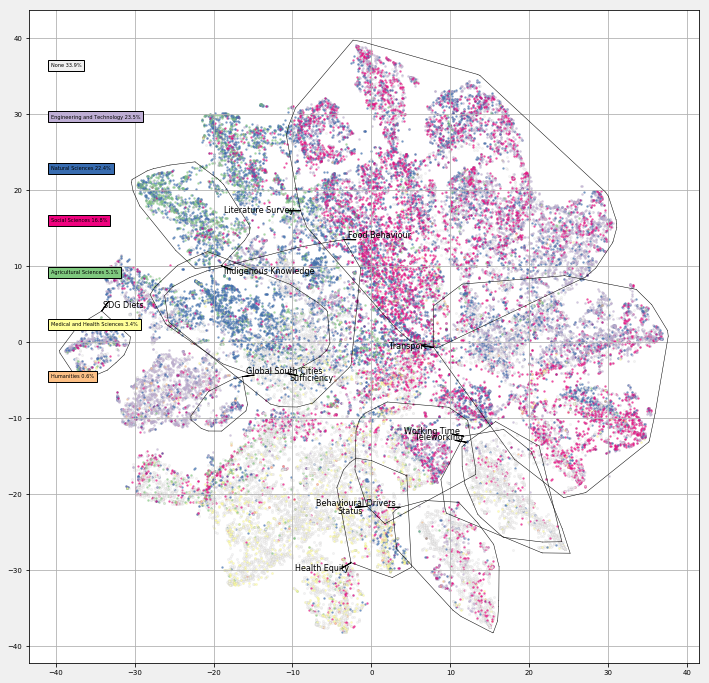

In [30]:


fig, ax = plt.subplots( figsize=(12,12))
tplots.plot_tsne(
    r_ind,
    tsne_results,
    oecd_cats,
    no_oecd_ids,
    verbose=True,
    ax=ax,
    psize=5, #pointsize
    doc_sets=qdicts,
    t_thresh=0.8,
    eps=3 # Input for clustering, higher values allow larger distances between docs 
)

fig.patch.set_facecolor('#f0f0f0') 

plt.show()

calculating points took 0.440s.


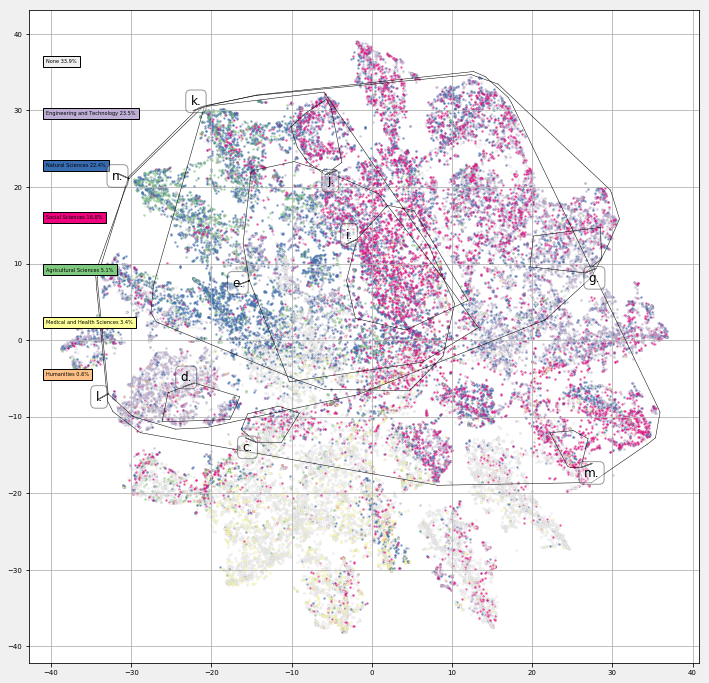

In [41]:
import importlib
importlib.reload(tmv_app.utils.plotting)

p2 = Project.objects.get(pk=148)
qs2 = p2.query_set.filter(
    database="WoS",title__iregex="^[a-z]\."
).order_by('title')

qdicts_2 = []
for q in qs2:
    qd = {
        'title': q.title[:2],
        'docs': list(q.doc_set.all().values_list('pk', flat=True))
    }
    qdicts_2.append(qd)
    
fig, ax = plt.subplots( figsize=(12,12))
tplots.plot_tsne(
    r_ind,
    tsne_results,
    oecd_cats,
    no_oecd_ids,
    verbose=True,
    ax=ax,
    psize=5, #pointsize
    doc_sets=qdicts_2,
    t_thresh=0.8,
    eps=3, # Input for clustering, higher values allow larger distances between docs 
    min_cluster=6, # The minimum number of docs in a cluster
    clabel_size=12 # We can play with the label size of the cluster labels here
)

fig.patch.set_facecolor('#f0f0f0') 

plt.show()

### Now we'll try and put these in the topic space of the big climate change query

Those documents that are in both are highlighted

calculating points took 1.463s.


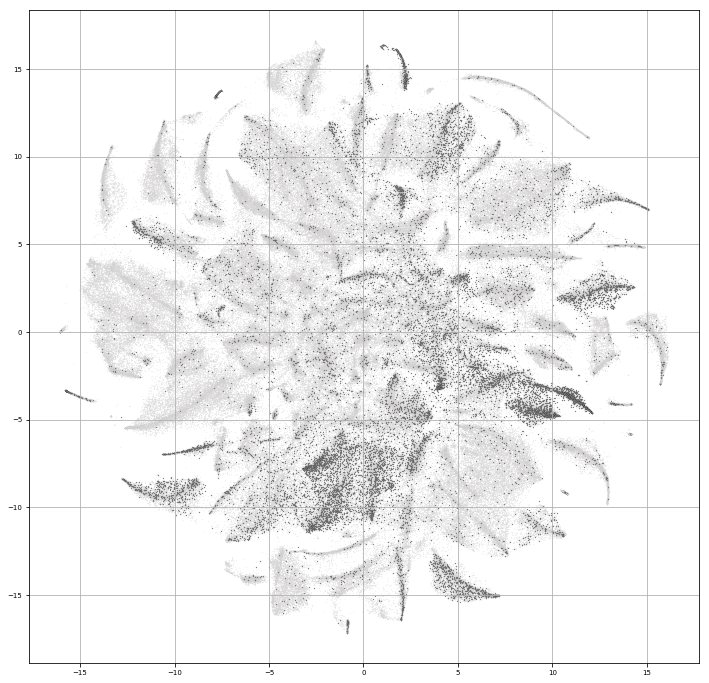

In [56]:
r_ind_cc = np.load('/home/galm/projects/cc-topography/tsne_results/data/run_1429_s_0_r_ind.npy')
tsne_results_cc = np.load('/home/galm/projects/cc-topography/tsne_results/data/run_1429_s_0_p50.npy')

qdocs = Doc.objects.filter(query=stat.query).values_list('pk',flat=True)

highlight_docs = np.argwhere(np.isin(r_ind_cc,qdocs))

fig, ax = plt.subplots( figsize=(12,12))

tmv_app.utils.plotting.plot_tsne(
    r_ind_cc,tsne_results_cc, [],
    r_ind_cc, ax=ax,
    verbose=True, hdoc=highlight_docs
)

plt.show()

In [59]:
colors = ['#7fc97f','#beaed4','#fdc086','#ffff99','#386cb0','#f0027f','#F0F0F0']
no_oecd_ids_cc = r_ind_cc
stat_cc = RunStats.objects.get(pk=1429)
q_cc = stat_cc.query

oecd_cats_cc = [
    {'wc__oecd': 'Agricultural Sciences'},
    {'wc__oecd': 'Engineering and Technology'},
    {'wc__oecd': 'Humanities'},
    {'wc__oecd': 'Medical and Health Sciences'},
    {'wc__oecd': 'Natural Sciences'},
    {'wc__oecd': 'Social Sciences'},
    {'wc__oecd': None}
]

oecd_df = pd.DataFrame()
for i,c in enumerate(oecd_cats_cc):
    ds = Doc.objects.filter(query=q_cc,wc__oecd=c['wc__oecd']).values_list('id', flat=True)
    c['docs'] = list(set(ds) & set(r_ind_cc))
    oecd_df = pd.concat([oecd_df,pd.DataFrame({
        "oecd": c['wc__oecd'], "doc": c['docs']
    })])
    c['n_docs'] = len(c['docs'])
    c['name'] = c['wc__oecd']
    c['color'] = colors[i]
    c["dis"] = np.argwhere(np.isin(r_ind_cc,c['docs']))
    no_oecd_ids_cc = no_oecd_ids_cc[np.isin(no_oecd_ids_cc,c['docs'],invert=True)]
    
from operator import itemgetter
oecd_cats_cc = sorted(oecd_cats_cc, key=itemgetter('n_docs'), reverse=True)

calculating points took 2.187s.


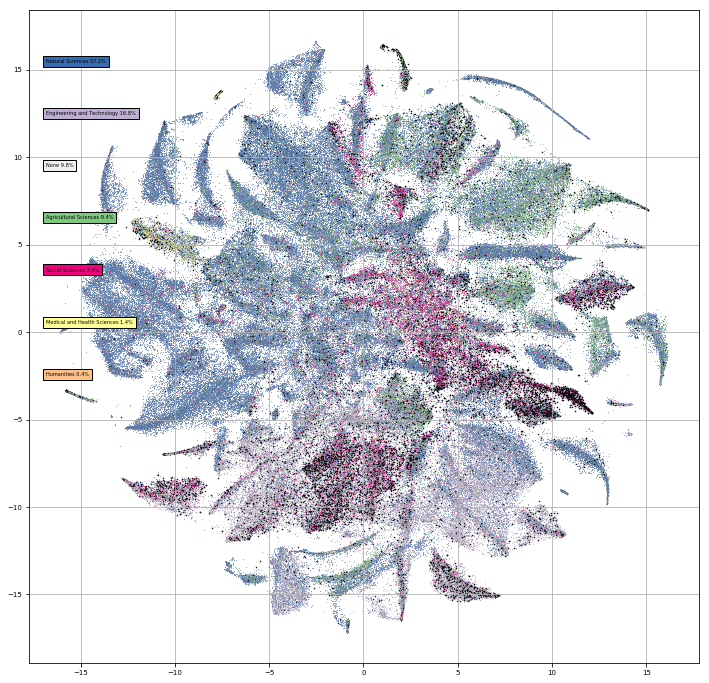

In [62]:
import importlib
importlib.reload(tmv_app.utils.plotting)

fig, ax = plt.subplots( figsize=(12,12))

tmv_app.utils.plotting.plot_tsne(
    r_ind_cc,tsne_results_cc, oecd_cats_cc,
    no_oecd_ids_cc, ax=ax,
    verbose=True, hdoc=highlight_docs
)

plt.show()